In [1]:
!unzip entity-annotated-corpus.zip

unzip:  cannot find or open entity-annotated-corpus.zip, entity-annotated-corpus.zip.zip or entity-annotated-corpus.zip.ZIP.


In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from transformers import BertTokenizer, BertModel

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

2021-09-18 01:04:13.879902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
datafile = '../input/entity-annotated-corpus/ner_dataset.csv'

In [5]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [10]:
df.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

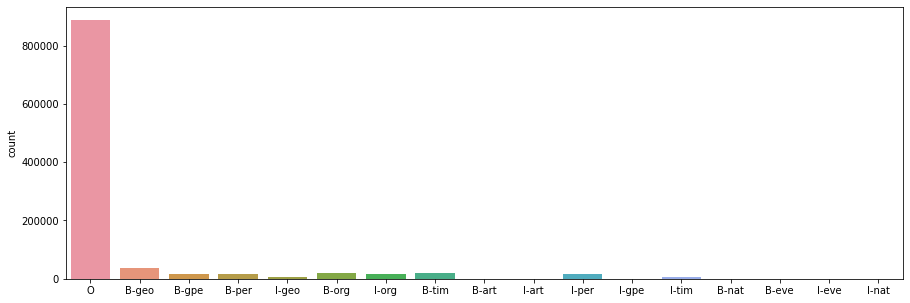

In [7]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [8]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func) #take words and tag from df
lines = [s for s in group] # convert to list

In [9]:
sentences = [[tokens[0] for tokens in line] for line in lines] # separate the list
tags = [[tokens[1] for tokens in line] for line in lines]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

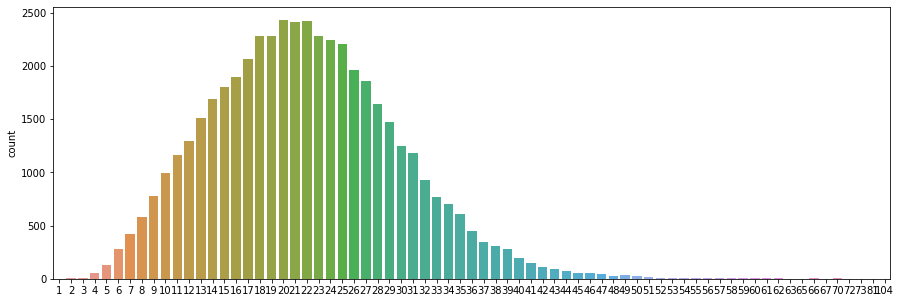

In [10]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [11]:
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [12]:
MAX_LEN = 60

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

In [15]:
def convert_to_id(tokens, tokenizer, max_input_length=MAX_LEN):
    tokens = tokens[:max_input_length-1]
    tokens = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens)
    return tokens

def cut_tags(tag, max_input_length=MAX_LEN):
    tags = tag[:max_input_length-1]
    return tags

In [16]:
%%time
sentences_ids = [convert_to_id(line, tokenizer) for line in sentences]
tags = [cut_tags(tag) for tag in tags]

CPU times: user 1.34 s, sys: 7.74 ms, total: 1.35 s
Wall time: 1.35 s


In [53]:
len(sentences_ids), len(tags)

(47959, 47959)

In [18]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [19]:
def build_vocab(tags, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter(chain(*tags))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [20]:
tags_vocab = build_vocab(tags)
print("Total vocabulary size: {}".format(len(tags_vocab)))

Total vocabulary size: 18


In [21]:
tags_ids = [[tags_vocab('<pad>')] + [tags_vocab(t) for t in tag] for tag in tags]

In [22]:
tags_ids

[[0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
 [0,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  5,
  1,
  1,
  1,
  1,
  1],
 [0,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  6,
  1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0,
  2,
  1,
  1,
  7,
  8,
  1,
  4,
  1,
  2,
  1,
  3,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [0,
  7,
  8,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  7,
  3,
  1,
  1,
  2,
  1,
  2,
  1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0,
  3,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [23]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences_ids, tags_ids, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

In [24]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]

        return torch.LongTensor(sentence), torch.LongTensor(tag)

In [25]:
train_dataset = NERDataset(train_sentences, train_tags)
valid_dataset = NERDataset(valid_sentences, valid_tags)
test_dataset = NERDataset(test_sentences, test_tags)

In [26]:
BATCH_SIZE = 8

In [27]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels

In [28]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [29]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape

(torch.Size([8, 36]), torch.Size([8, 36]))

In [30]:
class NERTagger(nn.Module):
    def __init__(self, output_dim, dropout):
        super().__init__()
        
        # bert model
        self.bert = BertModel.from_pretrained('bert-base-cased')
        
        # bert model hidden size
        d_model = self.bert.config.to_dict()['hidden_size']
        
        # prediction layer
        self.fc = nn.Linear(d_model, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        # text => [batch_size, seq_len]

        embedded = self.dropout(self.bert(text)[0])
        # only take the outputs, pooled output is not required
        # embedded => [batch_size, seq_len, d_model]

        predictions = self.fc(self.dropout(embedded))
        # predictions => [batch_size, seq_len, output_dim]

        return predictions


In [31]:
OUTPUT_DIM = len(tags_vocab)
DROPOUT = 0.4

model = NERTagger(OUTPUT_DIM, DROPOUT)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
model = model.to(device)

In [33]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 108,324,114 trainable parameters


In [35]:
LR = 5e-5
TAG_PAD_IDX = tags_vocab('<pad>')

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX).to(device)

In [51]:
import torch, torchvision
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [37]:
def train(model, iterator, criterion, optimizer):
    model.train()

    epoch_loss = 0

    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)
        # text => [seq_len, batch_size]
        # tags => [seq_len, batch_size]

        optimizer.zero_grad()

        logits = model(text)
        # logits => [batch_size, seq_len, output_dim]

        logits = logits.view(-1, logits.shape[-1])
        # logits => [batch_size * seq_len, output_dim]

        tags = tags.view(-1)
        # tags => [batch_size * seq_len]

        loss = criterion(logits, tags)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [batch_size, seq_len]
            # tags => [batch_size, seq_len]

            optimizer.zero_grad()

            logits = model(text)
            # logits => [batch_size, seq_len, output_dim]

            logits = logits.view(-1, logits.shape[-1])
            # logits => [batch_size * seq_len, output_dim]

            tags = tags.view(-1)
            # tags => [batch_size * seq_len]

            loss = criterion(logits, tags)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [54]:
N_EPOCHS = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, criterion, optimizer)
    valid_loss = evaluate(model, valid_data_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 5m 19s
	Train Loss: 0.106 | Val. Loss: 0.110
Epoch: 02 | Epoch Time: 5m 21s
	Train Loss: 0.084 | Val. Loss: 0.117


In [55]:
torch.save(model,'./model2.pt')

In [43]:
def cal_metrics(iterator):
    model.eval()
    epoch_loss = 0
    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [seq_len, batch_size]
            # tags => [seq_len, batch_size]

            logits = model(text)
            # logits => [seq_len, batch_size, output_dim]

            predictions = logits.argmax(-1)

            fin_outputs.extend(predictions.detach().cpu().numpy().tolist())
            fin_targets.extend(tags.detach().cpu().numpy().tolist())

    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)

In [56]:
cal_metrics(test_data_loader)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4796
           1       1.00      1.00      1.00      4795
           2       0.91      0.92      0.92      2496
           3       0.94      0.91      0.93      1303
           4       0.98      0.93      0.96      1688
           5       0.83      0.77      0.80      1623
           6       0.81      0.89      0.85       595
           7       0.87      0.91      0.89      1361
           8       0.87      0.97      0.92      1071
           9       0.86      0.81      0.83       879
          10       0.88      0.83      0.85       395
          11       0.50      0.05      0.09        42
          12       1.00      0.08      0.15        25
          13       0.21      0.92      0.34        12
          14       0.83      0.67      0.74        15
          15       1.00      0.25      0.40         4
          16       0.81      0.42      0.55        31
          17       0.40    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
writer.flush()
writer.close()

In [59]:
%reload_ext tensorboard

In [60]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6008 (pid 1303), started 0:28:26 ago. (Use '!kill 1303' to kill it.)